# PRA for 349 stocks from GPW 

## functions and data

In [1]:
from functions import pd, np, plt, load_data_foreign, load_data_pol, concat_and_select, calculate_returns, curve_fit
from matplotlib.colors import TwoSlopeNorm
from matplotlib.cm import ScalarMappable
# import numpy as np
# import pandas as pd
from IPython.display import display, clear_output

import time
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams.update({
    'font.size': 14,             # base font size
    'axes.titlesize': 18,        # title
    'axes.labelsize': 16,        # x and y labels
    'xtick.labelsize': 12,       # tick labels
    'ytick.labelsize': 12,
    'legend.fontsize': 14,       # legend
    'figure.titlesize': 20, 
    'savefig.dpi': 300,
    'savefig.bbox':'tight'
    # 'figure.figsize': (23.4, 16.5, )       # figure title if using plt.suptitle
})

In [2]:
# numpy version for calculating random matrices
def compute_D_matrix_fast(df, df_count):
    eta = df.values  # shape: (T, N)
    T, N = eta.shape

    # Generate random I ~ N(0, 1)
    I = np.random.normal(0, 1, T)  # tau = 0 ⇒ no shift needed
    I2_mean = np.mean(I ** 2)

    # Weight each row of eta by I (broadcast multiply)
    weighted_eta = eta * I[:, np.newaxis]  # shape: (T, N)

    numerator = (np.nan_to_num(weighted_eta).T @ np.nan_to_num(eta))  # shape: (N, N)

    # Final matrix
    D = numerator / df_count / I2_mean  # shape: (N, N)

    return D

def compute_D_matrix(df, index_series, tau, random_I=False, folder=None):
    eta_t = df.iloc[tau:]

    if random_I:
        n = len(df)
        I = np.random.normal(0, 1, n)
        I = pd.Series(I, index=df.index)
        tau=0
    else:
        I = index_series


    I2_mean = (I**2).mean()
    I_t_minus_tau = I.shift(tau).iloc[tau:].values  # shape: (T - τ, )

    # Weighted eta
    weighted_eta = eta_t * I_t_minus_tau[:, None]

    # Count of overlapping non-NaN values for normalization
    count = weighted_eta.notna().astype(int).T @ eta_t.notna().astype(int)

    # Numerator: dot product of weighted_eta and eta_t
    numerator = weighted_eta.fillna(0).T @ eta_t.fillna(0)

    # Final cross-correlation matrix
    D = numerator / count / I2_mean
    if folder:
        D.to_csv(folder+f'tau={tau}.csv')
    else:
        return pd.DataFrame(D, index=df.columns, columns=df.columns)

def read_D_matrix(dir, tau):
    D = pd.read_csv(f'C:/physics_masters/data/D_matrix/{dir}/tau={tau}.csv', index_col=0, header=0)
    return D

def read_eigvals(dir):
    D = pd.read_csv(f'C:/physics_masters/data/D_matrix/{dir}.csv', header=None)
    return D


def compute_random_eigenvals(df, N, name):
    all_eigvals = []
    
    count = df.notna().astype(int).T @ df.notna().astype(int)
    for _ in range(N):
        # random_m = compute_D_matrix(df, None, 0, True).values
        random_m = compute_D_matrix_fast(df, count)
        eigvals = np.linalg.eigvals(random_m)
        all_eigvals.append(eigvals.real)
        clear_output()
        print(f'\r{_}/{N}')  

    # Convert to DataFrame and save to CSV
    eigvals_df = pd.DataFrame(all_eigvals)
    eigvals_df.to_csv(f'C:/physics_masters/data/D_matrix/{name}.csv', index=False, header=False)

def compute_eigenvals(name):
    all_eigvals = []

    for t in range(1, 201):
        m = m = pd.read_csv(f'C:/physics_masters/data/D_matrix/{name}/tau={t}.csv', index_col=0, header=0)
        eigvals = np.linalg.eigvals(m)
        all_eigvals.append(eigvals.real)  

    # Convert to DataFrame and save to CSV
    eigvals_df = pd.DataFrame(all_eigvals)
    eigvals_df.to_csv(f'C:/physics_masters/data/D_matrix/{name}_eigenvals.csv', index_label=False, header=False)

def plot_D_matrix(D, tau, ax):
    ax.set_title(rf'D($\tau={tau}$)')
    return ax.imshow(D)


def marchenko_pastur_bounds(m, n):
    a, b =  (1-np.sqrt(n/m))**2, (1+np.sqrt(n/m))**2  #m, n inverse w.r.t. wikipedia definition
    return a, b
    

In [3]:
daily_omega = r"C:\\physics_masters\\data\\Bossa public market data\\pub\\daily\\omega\\"

dataframes = load_data_pol(daily_omega)
df_concat = concat_and_select(dataframes, min_non_na_fraction_col=0.1, min_non_na_fraction_row=0.0) #min nonna col 0.99
df_concat, index_series = calculate_returns(df_concat, 'log')

% of stocks remaining: 91.36%
% of dates remaining: 100.00%
Number of stocks: 349
Number of dates: 3616
% of nans: 40.49%


In [ ]:
# for tau in range(1, 201):
#     compute_D_matrix(df_concat, index_series, tau, folder=f'C:/physics_masters/data/D_matrix/{'GPW_full'}/')
#     clear_output()
#     print(f'\r{tau}')

200


In [ ]:
# compute_random_eigenvals(df_concat, 1000, f'gpw_full_random_I_eigenvals')

999/1000


In [ ]:
# compute_eigenvals('GPW_full')

## stationary correlations

In [4]:
C0 = df_concat.corr()
uniform = np.ones(len(C0)) / np.sqrt(len(C0))

eigval, eigvec = np.linalg.eig(C0)
market_mode  = eigvec[:, np.argmax(eigval)]
market_mode *= np.sign(np.dot(market_mode, uniform))  # Ensure positive sign for consistency
market_mode_lambda = eigval.max()

print(f'<e|v1> = {np.abs(np.dot(market_mode, uniform)):.3f}')

print(f'Market mode eigenvalue: {market_mode_lambda:.3f}')

<e|v1> = 0.873
Market mode eigenvalue: 24.654


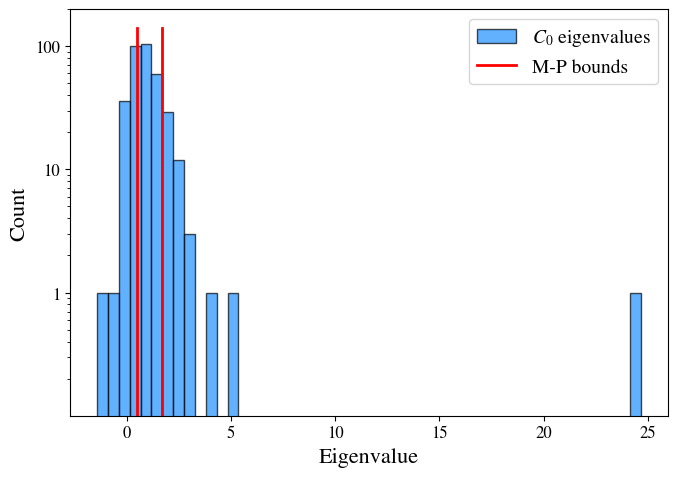

In [5]:
plt.figure(figsize=(7, 5))
plt.hist(eigval, bins=50, density=False, alpha=0.7, color='dodgerblue', edgecolor='k', label=r'$C_0$ eigenvalues')

a, b = marchenko_pastur_bounds(*df_concat.shape)
plt.plot([a, a], [140, 0], color='red', lw=2, label='M-P bounds')
plt.plot([b, b], [140, 0], color='red', lw=2)

#plt.title(r'Significance of $C_0$ eigenvalues')
plt.ylim(top=200, bottom=0.1)
plt.yscale('log')
plt.yticks([1, 10, 100], [1, 10, 100])

plt.legend()
plt.xlabel('Eigenvalue')
plt.ylabel('Count')
plt.tight_layout()

plt.savefig('c0_eigenvalues.png', bbox_inches='tight')

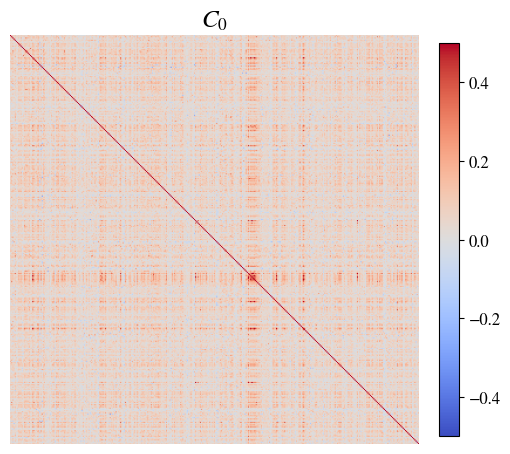

In [6]:
fig, axes = plt.subplots(1, 1, figsize=(5, 5), constrained_layout=True)
axes = np.array([axes])  # Ensure axes is a 2D array for consistency
# Set your asymmetric range and center
vmin = -0.5
vmax = 0.5
vcenter = 0.0
cmap = plt.cm.coolwarm  # or seismic

# Define the custom normalization
norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  # required for colorbar

for t, ax in zip([5], axes):
    m = pd.read_csv(f'C:/physics_masters/data/D_matrix/GPW_full/tau={t}.csv', index_col=0, header=0)
    m=C0
    im = ax.imshow(m, cmap=cmap, norm=norm)
    ax.set_title(f"τ = {t}")
    ax.set_title(r"$C_0$")

    ax.axis('off')

# Shared colorbar
cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), orientation='vertical', shrink=0.8)

plt.savefig('D_matrix_tau0.png', bbox_inches='tight')

## $D(\tau)$ matrices

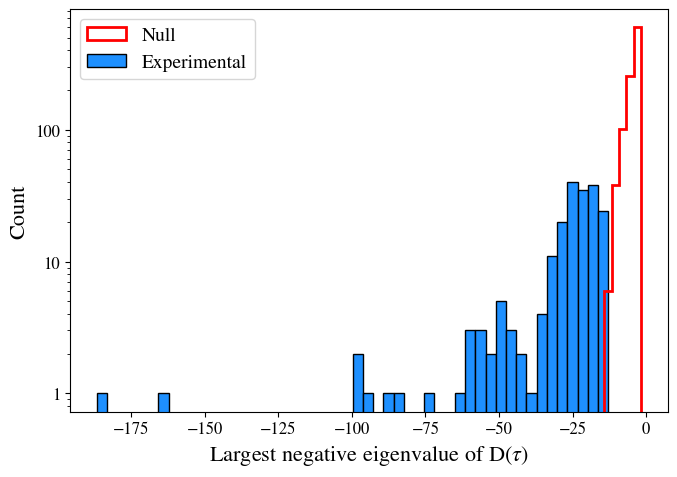

In [7]:
min_eigvals = read_eigvals('GPW_full_eigenvals').min(axis=1).values
eigvals_random = read_eigvals('GPW_full_random_I_eigenvals').min(axis=1).values
plt.figure(figsize=(7, 5))
plt.hist(eigvals_random, bins=5, histtype='step',  edgecolor='red', label='Null', linewidth=2)
plt.hist(min_eigvals, bins=50, color='dodgerblue', edgecolor='k', label='Experimental', )

# for t in [1, 2, 3]:
#     plt.text(min_eigvals[t-1]-0.2, 0.1, rf'$\tau={t}$')
#     plt.scatter(min_eigvals[t-1:t], [0.06], color='red', marker='x', lw=2, label='Experimental')
plt.yscale('log')
plt.xlabel(r'Largest negative eigenvalue of $\text{D}(\tau)$')
plt.ylabel(r'Count')
plt.yticks([1, 10 , 100], [1, 10, 100])
plt.legend()
plt.tight_layout()
plt.savefig('smallest_eigenvalues.png', bbox_inches='tight')

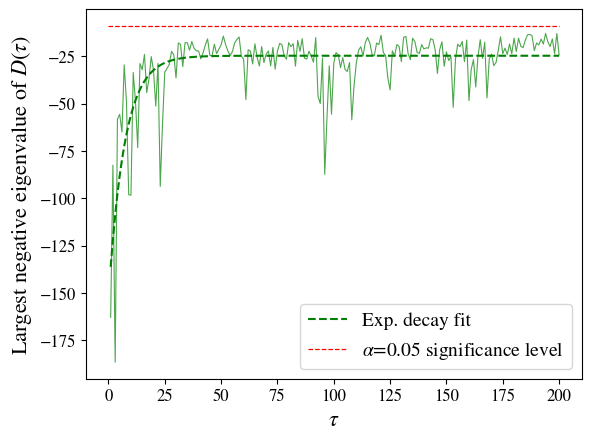

In [8]:
def exp_decay_with_offset(tau, A, tau_c, B):
    return A * np.exp(-tau / tau_c) + B

min_eigvals = read_eigvals('GPW_full_eigenvals').min(axis=1).values

plt.plot(range(1, 201), min_eigvals, color='green', lw=0.8, alpha=0.7)
plt.xlabel(r'$\tau$')
plt.ylabel(r'Largest negative eigenvalue of $D(\tau)$')
q = np.quantile(read_eigvals('gpw_full_random_I_eigenvals').min(axis=1).values, 0.05)

popt_Lsigma, _ = curve_fit(exp_decay_with_offset, list(range(1, 201)),min_eigvals, p0=(-1.0, 1.0, 0.0))
fit_Lsigma = exp_decay_with_offset(np.array(range(1, 201)), *popt_Lsigma) 
plt.plot(range(1, 201), fit_Lsigma, '--', lw=1.5, label=fr'Exp. decay fit', color='green')

plt.plot([-.1, 200], [q, q], '--', label=r'$\alpha$=0.05 significance level', color='red', lw=0.9)
plt.legend()
plt.savefig('gpw_full_eigenvals_min.png', bbox_inches='tight')

### how does the market mode rotate when I(t) changes? 

Text(0.5, 1.0, 'market mode = v with greatest |λ|')

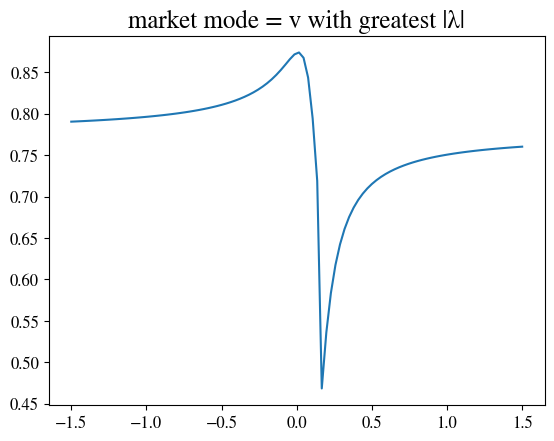

In [53]:
index_values =  np.linspace(-1.5, 1.5, 100)
tau=1

D = read_D_matrix('GPW_full', tau)

matrices = [C0+i*D for i in index_values]
eigvecs, eigvals = [], []
for m in matrices:
    vals, vecs = np.linalg.eig(m)
    n =  np.argmax(abs(vals))
    lambd = vals[n]
    v = vecs[:, n]
    eigvecs.append(v)
    eigvals.append(lambd)
plt.plot(index_values, [(v@uniform)*np.sign(v@uniform) for v in eigvecs], label='cosine with market mode')
plt.title('market mode = v with greatest |λ|')

more precise approach: market mode as the most extreme lambda eigenvector

In [34]:
def compute_random_eigenvals_with_C0(df, N, I):
    all_eigvals = []
    
    count = df.notna().astype(int).T @ df.notna().astype(int)
    for _ in range(N):
        # random_m = compute_D_matrix(df, None, 0, True).values
        random_m = compute_D_matrix_fast(df, count)
        eigvals = np.linalg.eigvals(C0+I*random_m)
        all_eigvals.append(eigvals.real)
        clear_output()
        print(f'\r{_}/{N}')  

    # Convert to DataFrame and save to CSV
    eigvals_df = pd.DataFrame(all_eigvals)
    return np.mean(eigvals_df.min(axis=1).values), np.mean(eigvals_df.max(axis=1).values)

In [35]:
index_values =  np.linspace(-1.5, 1.5, 10)
eigvals_min, eigvals_max = [], []
for i in index_values:
    min_eigval, max_eigval = compute_random_eigenvals_with_C0(df_concat, 100, i)
    eigvals_min.append(min_eigval)
    eigvals_max.append(max_eigval)

99/100


In [45]:
#index_values =  np.linspace(-1.5, 1.5, 100)
tau=1

D = read_D_matrix('GPW_full', tau)

matrices = [C0+i*D for i in index_values]
eigvecs1, eigvecs2, eigvals1, eigvals2 = [], [], [], []
for m in matrices:
    vals, vecs = np.linalg.eig(m)
    n1 =  np.argmin(vals)
    n2 =  np.argmax(vals)
    lambd1 = np.min(vals)
    lambd2 = np.max(vals)
    v1 = vecs[:, n1]
    v2 = vecs[:, n2]
    eigvecs1.append(v1)
    eigvecs2.append(v2)
    eigvals1.append(lambd1)
    eigvals2.append(lambd2)

Text(0.5, 1.0, 'significance of min/max eigenvalues of I*D(tau) + C0')

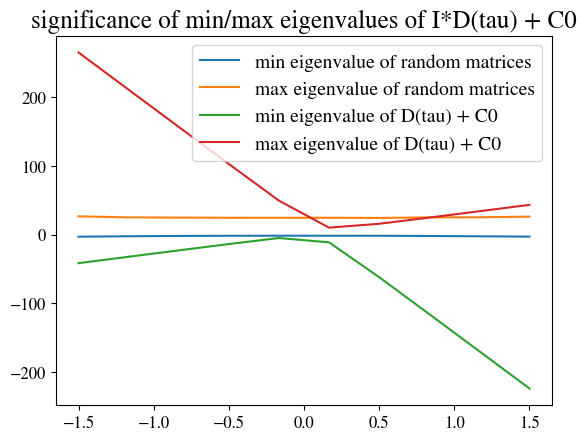

In [52]:
plt.plot(index_values, eigvals_min, label='min eigenvalue of random matrices')
plt.plot(index_values, eigvals_max, label='max eigenvalue of random matrices')
plt.plot(index_values, eigvals1, label='min eigenvalue of D(tau) + C0')
plt.plot(index_values, eigvals2, label='max eigenvalue of D(tau) + C0')
plt.legend()
plt.title('significance of min/max eigenvalues of I*D(tau) + C0')

Text(0.5, 1.0, 'cosine of (most significant) market mode with uniform')

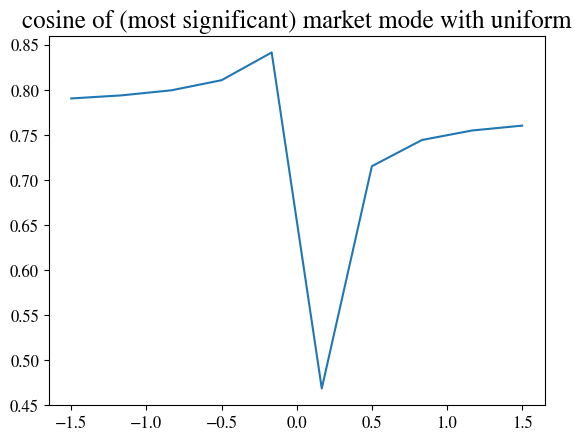

In [51]:
distr_center = 0.5*(np.array(eigvals_min) + np.array(eigvals_max))
dist1 = np.abs(np.array(eigvals1) - distr_center)
dist2 = np.abs(np.array(eigvals2) - distr_center)
cosines = np.where(dist1 < dist2, [v@uniform*np.sign(v@uniform )for v in eigvecs2], [v@uniform*np.sign(v@uniform ) for v in eigvecs1])
plt.plot(index_values, cosines, label='cosine with market mode')
plt.title('cosine of (most significant) market mode with uniform')

conclusion: results more or less the same, the shift is probably due to shift from positive to negatyve overall correlations

### for some fixed I(0) (otherwise I=0) how does the eigenvector of C(I) rotate?

In [ ]:
I = [-0.05, -0.1, -0.3]
matrices = [read_D_matrix('GPW_full', tau) for tau in range(1, 101)]

angles = []
for i in I:
    
    a = []
    eigvecs, eigvals = [], []
    for m in matrices:
        vals, vecs = np.linalg.eig(C0+i*m)
        n =  np.argmax(np.abs(vals))
        lambd = vals[n]
        v = vecs[:, n]
        sgn = np.sign(v@uniform)
        eigvecs.append(sgn*v)
        eigvals.append(lambd)
        a.append((sgn*v@uniform))

    angles.append(a)

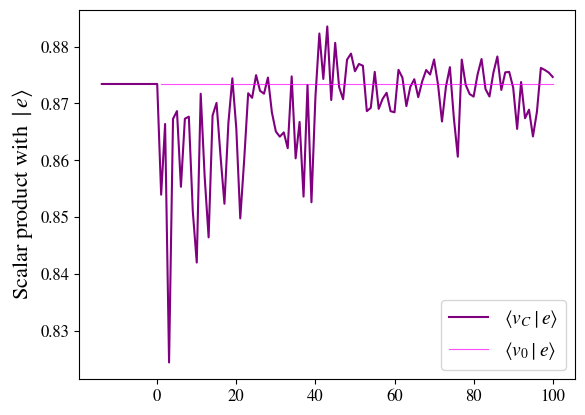

In [149]:
ref_angle = (market_mode@uniform)

plt.plot(range(-14, 101), 15*[ref_angle]+angles[1], label=rf'$\langle v_{{C}} \mid e \rangle$', color='purple')
plt.plot(range(1, 101), np.full(100, ref_angle), '-', label=r'$\langle v_0 \mid e \rangle$', color='magenta', alpha = 0.7, lw=0.8)
plt.ylabel(r'Scalar product with $\mid e \rangle$')

plt.legend(loc='lower right')
plt.savefig('gpw_I-.1_crises.png', bbox_inches='tight')